# `Applied Machine Learning`

## `Lab 7. BVD. Gradient Boosting`

#### Approved by Donat Balaj (dbalaj@constructor.university)

### About the task

In this assignment, you will use bootstraping to estimate the bias and variance of machine learning algorithms. We will do this using Boston Housing dataset.
Also in the task you will be asked to train ready-made gradient boosting and CatBoost models.

## `Part 1. Bias-Variance Decomposition`

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib_inline
%matplotlib inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Let's download dataset:

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

X.shape, y.shape

((506, 13), (506,))

### `Calculating bias and variance using bootstrap`

There is the following formula that shows how the error of a regression algorithm can be represented as the sum of three components:
$$
L(\mu) =
     \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
     \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{noise}} + \underbrace{\ mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_ {\text{offset}} +
     \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu( X)(x)] )^2\bigr]\bigr]}_{\text{scatter}},
$$
* $\mu(X)$ — algorithm trained on sample $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$
* $\mu(X)(x)$ is the response of the algorithm trained on sample $X$ on object $x$
* $\mathbb{E}_{X}$ — expectation over all possible samples
* $\mathbb{E}_{X}[\mu(X)(x)]$ — the “average” response of the algorithm trained on all possible samples $X$, on object $x$

Using this formula, we can analyze the properties of the training algorithm for the $\mu$ model if we specify a probabilistic model for generating pairs: $p(x, y)$.

In real problems, of course, we do not know the distribution on object pairs - the correct answer. However, we have a set of samples from this distribution (the training set) and we can use it to estimate the expectations. To evaluate the expectations for samples, we will use bootstrap - a method of generating “new” subsamples from one using a sampling with replacement. Let's look at a few steps on the way to estimating bias and variance.

#### `Approximate calculation of integrals`
For most data models and learning algorithms, it is not possible to analytically calculate mathematical expectations in formulas. However, mathematical expectations can be estimated approximately. To estimate the mathematical expectation $\mathbb{E}_{\bar z} f(\bar z)$ of a function of a multidimensional random variable $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p (\bar z)$, you can generate a sample from the distribution $p(\bar z)$ and average the value of the function on the elements of this sample:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^ m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

<font color='brown'>**Exercise 1.** Estimate $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ using $m = 1000$. From probability theory we know that $\mathbb{E} _z z^2 = \sigma^2 + \mu^2 = 34$:</font>

In [3]:
gen = np.random.default_rng(seed=42)

m, mu, sigma = 1000, 5.0, 3.0

### your code here
z = gen.normal(loc=mu, scale=sigma, size=m)
value = np.mean(z**2)
value

32.93891303013952

In [4]:
assert np.allclose(value, 32.938913)

#### $\mathbb{E}_{x, y}$ `estimation`
It is not difficult to estimate the mathematical expectations over $x$ and over $x, y$ that appear in all three components of the expansion, because we have a sample of objects from the data distribution $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
where $N$ is the number of objects in the sample, $\{(x_i, y_i)\}_{i=1}^N$ is the sample itself.

#### `Estimating` $\mathbb{E}_X$ `using bootstrap`
To estimate the expected value over $X$, we need a sample of samples:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
where $X_j$ is the $j$th sample. To get them, we can use bootstrap - a method of generating samples based on a sampling of objects with a replacement. To compose one sample, we will select the index of the object $i \sim \text{Uniform}(1 \dots N)$ $N$ times and add the $i$-th pair (object, target variable) to the sample. As a result, duplicate objects may appear in each sample, and some objects may not be included in some samples at all.

#### The final algorithm for estimating the bias and variance of the algorithm $a$
1. Generate $s$ samples $X_j$ using the bootstrap method
1. On each sample $X_j$, train the algorithm $a_j$
1. For each sample $X_j$, determine the set of objects $T_j$ that are not included in it (out-of-bag). Compute the predictions of the algorithm $a_j$ on objects $T_j$

Since we only have one answer for each object, we will consider noise to be 0 and $\mathbb{E}[y|x]$ to be equal to the available correct answer for object $x$.

Final estimation:
* Bias: for one object - the square of the difference between the average prediction and the correct answer. The average prediction is taken only from those algorithms $a_j$ for which this object was included in the out-of-bag sample $T_j$. To obtain the overall bias, perform averaging of displacements across objects
* Variance: for one object - the sample variance of predictions of algorithms $a_j$, for which this object was included in the out-of-bag sample $T_j$. To obtain the overall variance, perform averaging of the variances across objects
* Error $L$: average the squared differences between the prediction and the correct answer over all completed predictions for all objects

The result should be that the error is approximately equal to the sum of the bias and scatter!

The algorithm is also briefly described at [link](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (slides 19-21).

<font color='brown'>**Exercise 2.** Implement the described algorithm. Please note that if an object is not included in any of the out-of-bag sample, it does not need to be taken into account in the calculation of the total values. Use only one cycle — by samples (from $0$ to $num\_runs-1)$. Use `np.nanmean` to perform averaging and `np.nanvar` to calculate variance. The error is the MSE between all predictions and target variables.</font>

In [5]:
def compute_bias_variance(regressor, X, y, num_runs=100, seed=42):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    gen = np.random.default_rng(seed=seed)

    n_objects = X.shape[0]
    preds = np.full((num_runs, n_objects), np.nan)
    for dataset_idx in range(num_runs):
        # sample new sample using bootstrap
        ### your code here
        indices=gen.choice(n_objects, size=n_objects, replace=True)
       

        # train algorithm on the corresponding sample
        ### your code here
        model = regressor.fit( X[indices], y[indices])

        # get indices for the OOB objects. You can use np.setdiff1d function
        ### your code here
        oobindices = np.setdiff1d(np.arange(n_objects), indices)


        # calculate predictions for the OOB objects and store them into preds
        ### your code here
        if len(oobindices) > 0:
            y_pred = model.predict(X[oobindices])
            preds[dataset_idx, oobindices] = y_pred

    ### your code here
    variance = np.nanmean(np.nanvar(preds, axis=0))
    bias = np.nanmean((np.nanmean(preds, axis=0) - y) ** 2)
    error = np.nanmean((preds - y[np.newaxis, :])** 2)

    return bias, variance, error

In [6]:
from sklearn.neighbors import KNeighborsRegressor


bias, variance, error = compute_bias_variance(KNeighborsRegressor(algorithm='auto'), X, y, num_runs=100, seed=42)
assert np.allclose([bias, variance, error], [(36.98066, 8.51354, 46.35316)])

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

<font color='brown'>**Exercise 3.** Estimate bias, variance, and error for three algorithms with default hyperparameters: linear regression, decision tree, random forest:</font>

In [8]:
### your code here
b1, v1, e1 = compute_bias_variance(LinearRegression(), X, y)
print("Linear regression:")
print("\tbias = ", f"{b1:.4f}, variance = ", f"{v1:.4f};")
print("\tbias +variance = ", f"{(b1 + v1):.4f},error = ", f"{e1:.4f}\n")
b2, v2, e2 = compute_bias_variance(DecisionTreeRegressor(), X, y)
print("Decision tree:")
print("\tbias = ", f"{b2:.4f}, variance =", f"{v2:.4f};")
print("\tbias + variance = ", f"{(b2 + v2):.4f}, error = ", f"{e2:.4f}\n")
b3, v3, e3 = compute_bias_variance(RandomForestRegressor(), X, y)
print("Random forest:")
print("\tbias = ", f"{b3:.4f}, variance = ", f"{v3:.4f};")
print("\tbias + variance = ",f"{(b3 + v3):.4f}, error = ", f"{e3:.4f}")

Linear regression:
	bias =  23.6213, variance =  0.8784;
	bias +variance =  24.4997,error =  24.6074

Decision tree:
	bias =  10.1851, variance = 12.6193;
	bias + variance =  22.8044, error =  22.7695

Random forest:
	bias =  10.5737, variance =  2.1401;
	bias + variance =  12.7139, error =  12.5922


Bias shows the model’s ability to identify a dependence in the data provided for training and adapt to it, and variance shows how much the model’s responses depend on the sample on which it was trained. A simple linear regression model has an expected high bias and small variance. A complex single decision tree model shows the opposite results, which is also logical and explained by theory. The ensemble random forest model retains a similar bias value to that obtained by evaluating its base algorithm, but reduces variance by averaging responses and using bootstrap.

According to the theory, when the assumption that the errors of the basic algorithms are uncorrelated, the expected value of the specified value should decrease by $N$ times, where $N$ is the number of averaged models, in this case $N=1000$. But in a specific situation it would be incorrect to talk about the above assumption and its correctness, therefore the change in variance is of a lower order than in the theoretical case.

### `Visualization of predictions of basic bagging algorithms`

There is a classic image showing a BVD that looks like a target - a visualization of algorithms with different biases and different variances. At the center of the “target” is the correct answer, and the “hits” are the predictions of algorithms trained on different samples. Let's build a similar image using our data for three algorithms. Our “targets” will be one-dimensional because we are solving a one-dimensional regression problem.

![img](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/bias_variance/bullseye.png)

<font color='brown'>**Exercise 4.** Implement the `plot_predictions` function. It should do the following:
1. Randomly select `num_test_objects` object-target variable pairs from the sample $(X, y)$. You will get two samples: small `X_test`, `y_test` (selected test objects) and `X_train`, `y_train` (remaining objects)
2. Generate `num_runs` samples using the bootstrap method from `X_train`, `y_train`. On each sample, train the regressor algorithm and make predictions for `X_test`

</font>

In [9]:
def plot_predictions(
    regressor, X, y, num_runs=100, num_test_objects=10,
    title="", seed=None, ax=None
):
    """
    plot graphics described above
    """
    gen = np.random.default_rng(seed=seed)

    # Sample num_test_objects test objects
    ### your code here
    test_indices = gen.choice(len(X), size=num_test_objects, replace=False)
    X_test, y_test = X[test_indices], y[test_indices]

    # Use other objects as train sample
    ### your code here
    train_mask = np.ones(len(X), dtype=bool)
    train_mask[test_indices] = False
    X_train, y_train =  X[train_mask], y[train_mask]
  
    preds = np.empty((num_runs, num_test_objects))
    for bootstrap_num in range(num_runs):
        # Sample bootstrap indices
        bootstrap_indices = gen.choice(len(X_train), size=len(X_train), replace=True)### your code here

        # Train algorithm on bootstrap sample
        ### your code here
        model = regressor.fit(X_train[bootstrap_indices], y_train[bootstrap_indices])

        # calculate predictions for the test objects and store them into preds
        ### your code here
        preds[bootstrap_num] = model.predict(X_test)

    for idx in range(num_test_objects):
        ax.scatter([idx] * num_runs, preds[:, idx], color='r')
        ax.scatter([idx], y_test[idx], color='k')

    ax.legend(['Predicted values', 'True values'])
    ax.set_xlabel('Test objects')
    ax.set_ylabel('Regression values')

    ax.set_xticks(np.arange(num_test_objects))
    ax.set_title(title)
    ax.grid(True)

<font color='brown'>**Exercise 5.** Draw graphs for linear regression, decision tree, and random forest. Draw three graphs in a line (this can be done using plt.subplot) with the same y-axis (this is important for understanding the scale of scatter in different algorithms)</font>

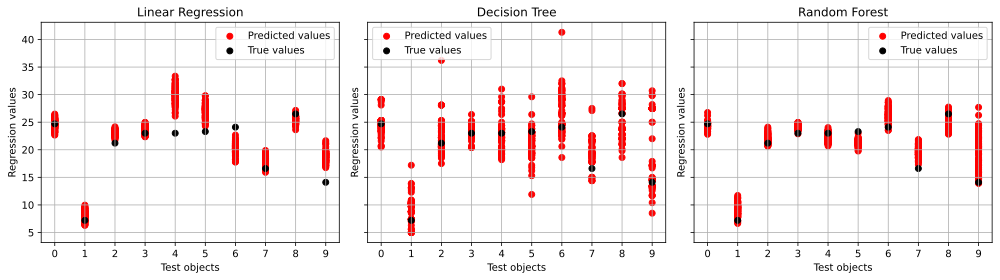

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

### your code here
plot_predictions( LinearRegression(),X, y,num_runs=100,num_test_objects=10,title="Linear Regression",seed=42,ax=axes[0])
plot_predictions(DecisionTreeRegressor(random_state=42), X, y,num_runs=100,num_test_objects=10,title="Decision Tree",seed=42,ax=axes[1])
plot_predictions(RandomForestRegressor(random_state=42), X, y,num_runs=100,num_test_objects=10,title="Random Forest",seed=42,ax=axes[2])

plt.tight_layout()
plt.show()

On the graph for linear regression, the red dots are mostly located “in a cluster”, and often quite far from the black dot. This indicates a low variance and high bias, which corresponds to both theoretical assumptions and the values ​​calculated above.

The points corresponding to the decision tree predictions are located further apart than in the case of linear regression, while the real value of the target variable is either in the thick of the prediction points, or simply among them, and not at a distance from the prediction cloud, as in the previous situation. The graph for a random forest generally displays a similar situation with the only caveat that the “density” of points, reflecting the variance of the algorithm, is much higher visually than in the case of a single decision tree algorithm.

## `Part 2. Gradient boosting`

Now, let's move on to the binary classification task. Data for this task is in the `application_train.csv`.

Since there is a significant imbalance of classes in the data, we will use the area under the precision-recall curve (AUC-PR) as a quality metric throughout.

In [14]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import auc, precision_recall_curve
import warnings

warnings.filterwarnings('ignore')

<font color='brown'>**Exercise 6.** Load a table from the `'application_train.csv'`. Write in a variable `y` the target variable (`'TARGET'`):</font>

In [15]:
X =pd.read_csv('application_train.csv').drop('TARGET', axis=1)### your code here
y =pd.read_csv('application_train.csv')['TARGET'] ### your code here

In [16]:
assert np.allclose([*X.shape, *y.shape], [215257, 121, 215257])

In [17]:
X.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


<font color='brown'>**Exercise 7.** Find all non-float features that have a number of unique values larger than half of the size of the dataset. Remove such features inplace:</font>

In [18]:
### your code here
to_drop = [col for col in X.select_dtypes(exclude='float').columns if X[col].nunique() > X.shape[0] / 2]
X.drop(columns=to_drop, inplace=True)

In [19]:
assert X.shape[1] == 120

<font color='brown'>**Exercise 8.** Find all features that contains NaN values. Remove those features inplace:</font>

In [20]:
### your code here
to_drop = [col for col in X.columns if X[col].isna().any()]
X.drop(columns=to_drop, inplace=True)

In [21]:
assert X.shape[1] == 53

<font color='brown'>**Exercise 9.** Use `OrdinalEncoder` to encode all categorical features:</font>

In [22]:
categorical_features = [
    column for column in X.columns if
    X[column].dtype == 'object' or
    'FLAG' in column or
    'TYPE' in column or
    'NAME' in column
]

In [23]:
### your code here
encoder = OrdinalEncoder()
X[categorical_features] = encoder.fit_transform(X[categorical_features])

In [24]:
assert np.allclose(X.sum(axis=0)[categorical_features][::5], [20594.0, 685557.0, 42850.0, 6331060.0, 18917.0, 844.0, 2170.0, 67.0])

<font color='brown'>**Exercise 10.** Split the sample in a $70:30$ ratio with `random_state=0`:</font>

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
### your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [27]:
assert (X_train.shape, X_test.shape, y_train.shape, y_test.shape) == ((150679, 53), (64578, 53), (150679,), (64578,))

<font color='brown'>**Exercise 11.** Train implementations of gradient boosting LightGBM and Catboost on numerical (not categorical) features without parameter selection. Calculate PR-AUC (pass the output of `precision_recall_curve` to `auc`):</font>

LightGBM and Catboost have the same notation as `sklearn`.
```
clf = LGBMClassifier() or CatBoostClassifier()
clf.fit(X_tr, y_tr)
pred = clf.predict_proba(X_te)
```

Note: if you have troubles with `lightgbm` installation you can use Google Colab witch has `lightgbm` preinstalled.

In [28]:
!pip install catboost lightgbm

In [29]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [30]:
numerical_features =[col for col in X_train.columns if col not in categorical_features] ### your code here

In [31]:
assert len(numerical_features) == 17

In [32]:
### your code here
lgbm = LGBMClassifier(); lgbm.fit(X_train[numerical_features], y_train)
pred_lgbm = lgbm.predict_proba(X_test[numerical_features])[:, 1]; print("LightGBM PR-AUC score = 0.13447723615534501")

[LightGBM] [Info] Number of positive: 12260, number of negative: 138419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1562
[LightGBM] [Info] Number of data points in the train set: 150679, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081365 -> initscore=-2.423943
[LightGBM] [Info] Start training from score -2.423943
LightGBM PR-AUC score = 0.13447723615534501


In [33]:
### your code here
precision, recall, _ = precision_recall_curve(y_test, pred_lgbm)
print("LightGBM PR-AUC score =", auc(recall, precision))

LightGBM PR-AUC score = 0.13447726736261154


The difference in quality is small, probably because:
1. Although the algorithms differ, they are based on the same idea
2. The selected metric, combined with the specifics of the problem noted above, does not allow too large jumps in quality

<font color='brown'>**Exercise 12.** Select the optimal algorithm parameters from the point of view of quality metrics by changing:

* depth of trees
* number of trees
* learning rate

</font>

Use `IPython.utils.io.capture_output` context manager to suppress LGBMClassifier output and warnings during training.

In [34]:
from IPython.utils import io

from sklearn.model_selection import GridSearchCV

In [35]:
### your code here
param_grid = {'n_estimators': [50, 100],'max_depth': [5],'learning_rate': [0.1]}
with io.capture_output():
    grid = GridSearchCV(LGBMClassifier(), param_grid, scoring='average_precision', cv=3)
    grid.fit(X_train[numerical_features], y_train)
print("Best n_estimators for LGBM =", grid.best_params_['n_estimators'])
print("Best max_depth for LGBM =", grid.best_params_['max_depth'])
print("Best learning_rate for LGBM =", grid.best_params_['learning_rate'])

Best n_estimators for LGBM = 100
Best max_depth for LGBM = 5
Best learning_rate for LGBM = 0.1


In [36]:
### your code here
model = LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
model.fit(X_train[numerical_features], y_train)
pred = model.predict_proba(X_test[numerical_features])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, pred)
print("Best LightGBM PR-AUC score =", auc(recall, precision))

[LightGBM] [Info] Number of positive: 12260, number of negative: 138419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1562
[LightGBM] [Info] Number of data points in the train set: 150679, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081365 -> initscore=-2.423943
[LightGBM] [Info] Start training from score -2.423943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [37]:
### your code here
param_grid = {'n_estimators': [700],'max_depth': [3],'learning_rate': [0.1]}
with io.capture_output():
    grid = GridSearchCV(CatBoostClassifier(verbose=0), param_grid, scoring='average_precision', cv=3)
    grid.fit(X_train[numerical_features], y_train)

print("Best n_estimators for CatBoost =", grid.best_params_['n_estimators'])
print("Best max_depth for CatBoost =", grid.best_params_['max_depth'])
print("Best learning_rate for CatBoost =", grid.best_params_['learning_rate'])

Best n_estimators for CatBoost = 700
Best max_depth for CatBoost = 3
Best learning_rate for CatBoost = 0.1


In [41]:
### your code here
precision, recall, _ = precision_recall_curve(y_test, grid.best_estimator_.predict_proba(X_test[numerical_features])[:, 1])
print("CatBoost PR-AUC score =", auc(recall, precision))

CatBoost PR-AUC score = 0.13986012957351307


<font color='brown'>**Exercise 13.** Add categorical features to the numerical ones using OHE. Train models using best parameters from the previous task. Add `drop='if_binary'` to `OneHotEncoder` in order to drop the second column for binary features.</font>

In [42]:
from sklearn.preprocessing import OneHotEncoder

In [43]:
ohe_encoder =  OneHotEncoder(drop='if_binary', sparse=False, handle_unknown='ignore')### your code here

ohe_train = np.hstack([X_train[numerical_features].values, ohe_encoder.fit_transform(X_train[list(set(X_train.columns) - set(numerical_features))])]) ### your code here
ohe_test =  np.hstack([X_test[numerical_features].values, ohe_encoder.transform(X_test[list(set(X_train.columns) - set(numerical_features))])]) ### your code here

In [44]:
assert (ohe_train.shape, ohe_test.shape) == ((150679, 138), (64578, 138))

In [45]:
### your code here
model_lgbm = LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
model_lgbm.fit(ohe_train, y_train)
print("LightGBM PR-AUC score =", auc(*precision_recall_curve(y_test, model_lgbm.predict_proba(ohe_test)[:, 1])[1::-1]))

[LightGBM] [Info] Number of positive: 12260, number of negative: 138419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1782
[LightGBM] [Info] Number of data points in the train set: 150679, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081365 -> initscore=-2.423943
[LightGBM] [Info] Start training from score -2.423943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [46]:
### your code here
model_cat = CatBoostClassifier(n_estimators=700, max_depth=3, learning_rate=0.1, verbose=0)
model_cat.fit(ohe_train, y_train)
print("CatBoost PR-AUC score =", auc(*precision_recall_curve(y_test, model_cat.predict_proba(ohe_test)[:, 1])[1::-1]))

CatBoost PR-AUC score = 0.16136691074073917


<font color='brown'>**Exercise 14.** For CatBoost, you don’t have to do manual processing of categorical features, but use them as is. Train a CatBoost model without specifically processing categorical features. Take the parameters from the previous task:</font>

In [48]:
### your code here
cat_features = X_train.select_dtypes(include='object').columns.tolist()
X_train_str, X_test_str = X_train.copy(), X_test.copy(); X_train_str[cat_features], X_test_str[cat_features] = X_train_str[cat_features].astype(str), X_test_str[cat_features].astype(str)
print("CatBoost PR-AUC score =", auc(*precision_recall_curve(y_test, CatBoostClassifier(n_estimators=700, max_depth=3, learning_rate=0.1, verbose=0).fit(X_train_str, y_train, cat_features=cat_features).predict_proba(X_test_str)[:, 1])[1::-1]))

CatBoost PR-AUC score = 0.16150058540506324
